# Tarea 4: Funciones, Modelos Personalizados y Ecuaciones Diferenciales

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist, cifar10

import numpy as np
import matplotlib.pyplot as plt

import mlflow
import dagshub

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles: {len(gpus)}")

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
    
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Crecimiento de memoria GPU configurado")
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")
else:
    print("No se detectó GPU. El entrenamiento usará CPU.")

GPUs disponibles: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Crecimiento de memoria GPU configurado


In [5]:
dagshub.init(repo_owner='404brainnotfound-ai', repo_name='RNA', mlflow=True)
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Accessing as 404brainnotfound-ai

Initialized MLflow to track repo "404brainnotfound-ai/RNA"

Repository 404brainnotfound-ai/RNA initialized!

Tracking URI: https://dagshub.com/404brainnotfound-ai/RNA.mlflow


---
## Problema 1: Capa RGB a Escala de Grises

In [6]:
class CapaGrises(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CapaGrises, self).__init__(**kwargs)
        self.rgb_weights = tf.constant([0.299, 0.587, 0.114], dtype=tf.float32)
    
    def call(self, inputs):
        r = inputs[:, :, :, 0]
        g = inputs[:, :, :, 1]
        b = inputs[:, :, :, 2]
        grises = 0.299 * r + 0.587 * g + 0.114 * b
        grises = tf.expand_dims(grises, axis=-1)
        return grises
    
    def get_config(self):
        config = super(CapaGrises, self).get_config()
        return config

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_test = x_test.astype(np.float32) / 255.0

print(f"Shape original: {x_test.shape}")
print(f"Rango: [{x_test.min():.2f}, {x_test.max():.2f}]")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Shape original: (10000, 32, 32, 3)
Rango: [0.00, 1.00]


In [8]:
with tf.device('/GPU:0' if gpus else '/CPU:0'):
    model_p1 = Sequential([
        Input(shape=(32, 32, 3)),
        CapaGrises(),])

model_p1.summary()

x_gray = model_p1.predict(x_test[:10], verbose=0)
print(f"Shape después: {x_gray.shape}")

I0000 00:00:1764034394.146374   23065 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2857 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_grises (CapaGrises)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

2025-11-24 19:33:14.421179: I external/local_xla/xla/service/service.cc:163] XLA service 0x7557740024c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-24 19:33:14.421229: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-11-24 19:33:14.494998: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


Shape después: (10, 32, 32, 1)


I0000 00:00:1764034394.942872   27120 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
test_img = x_test[0]
manual_gray = (0.299 * test_img[:,:,0] + 0.587 * test_img[:,:,1] + 0.114 * test_img[:,:,2])
layer_gray = x_gray[0, :, :, 0]
difference = np.abs(manual_gray - layer_gray).max()

print(f"Diferencia máxima: {difference:.10f}")
print("Correcto" if difference < 1e-6 else "Error")

Diferencia máxima: 0.0000000000
Correcto


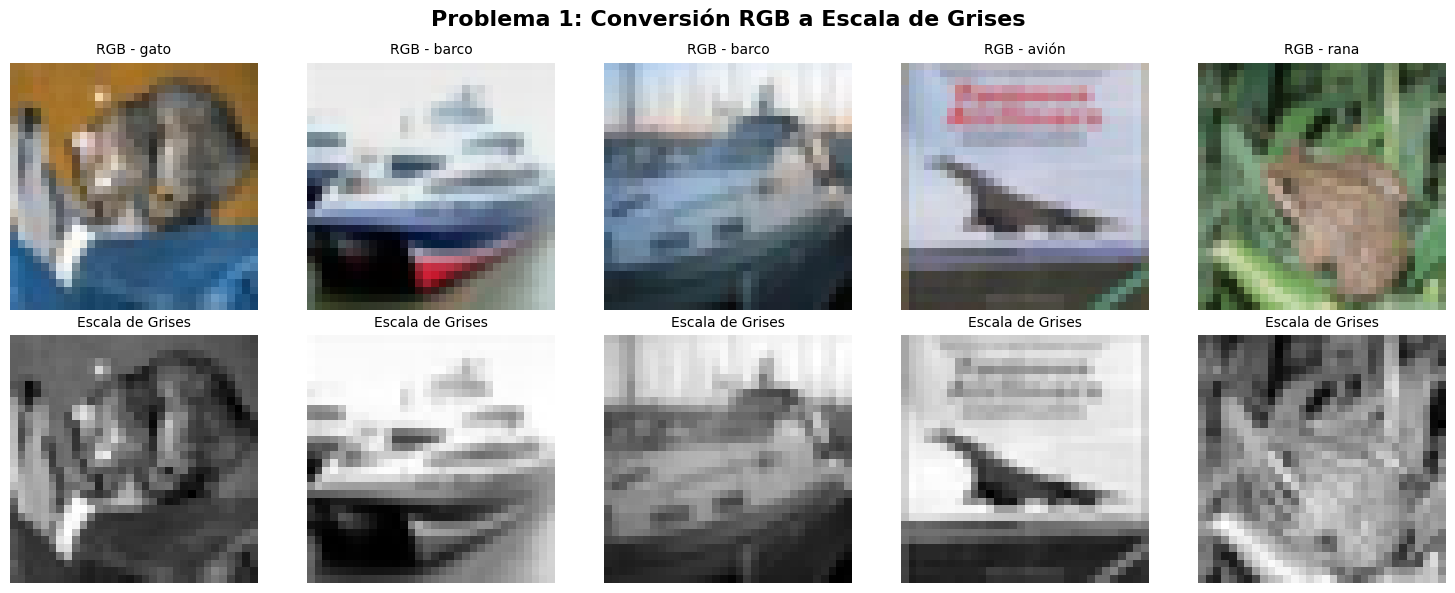

In [13]:
class_names = ['avión', 'auto', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Problema 1: Conversión RGB a Escala de Grises', fontsize=16, fontweight='bold')

for i in range(5):
    axes[0, i].imshow(x_test[i])
    axes[0, i].set_title(f'RGB - {class_names[y_test[i][0]]}', fontsize=10)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(x_gray[i, :, :, 0], cmap='gray')
    axes[1, i].set_title('Escala de Grises', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('problema1_resultado.png', dpi=300, bbox_inches='tight')
plt.show()